# LSTM Modelling 

In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings("ignore")

2023-07-28 11:46:47.154582: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 11:46:47.190488: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 11:46:47.191306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 11:46:48.124224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Refactor

In [2]:
dataset = pd.read_csv("../StationsDatasets/dataset.csv").drop(columns=["Unnamed: 0"])

In [3]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [4]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = np.delete(df, 2)

dataset = dataset.join(new_data)

In [5]:
dataset.to_csv("../StationsDatasets/dataset.csv")

## Correlation Features

In [6]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 10436.527125289169),
 ('ATemp', 10280.850373783074),
 ('Year', 7092.1562101395475),
 ('Humidity', 4553.546738421971),
 ('Hour', 2521.675519475486),
 ('WeatherSituation', 1577.7531873242183),
 ('Day', 1020.0092383643951),
 ('StationEnd', 221.11531013433412),
 ('Windspeed', 189.9517425616836),
 ('Holiday', 56.248513129294146),
 ('Weekday', 47.644297362870226),
 ('WorkingDay', 39.98836012369895)]


## LSTM

In [22]:
epochs = 1
batch_size = 1
verbose = 2

MSE = [1.4124974727630615, 1.4019839406013488, 1.4195882439613343, 1.3961206436157227, 1.4007801771163941, 1.3863590478897094, 1.4167989015579223, 1.4111652970314026]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [11]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-07-28 13:36:32.369127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 13:36:32.370937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 13:36:32.371994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190435/190435 - 172s - loss: 1.4550 - accuracy: 0.3345 - 172s/epoch - 905us/step


2023-07-28 13:39:25.003406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 13:39:25.004709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 13:39:25.005629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

192615/192615 - 166s - loss: 1.4138 - accuracy: 0.3445 - 166s/epoch - 860us/step
190894/190894 - 166s - loss: 1.4070 - accuracy: 0.3456 - 166s/epoch - 870us/step
190453/190453 - 164s - loss: 1.3993 - accuracy: 0.3483 - 164s/epoch - 864us/step
190564/190564 - 164s - loss: 1.4005 - accuracy: 0.3461 - 164s/epoch - 862us/step
190967/190967 - 165s - loss: 1.4116 - accuracy: 0.3450 - 165s/epoch - 865us/step
190597/190597 - 167s - loss: 1.4137 - accuracy: 0.3455 - 167s/epoch - 874us/step
190599/190599 - 165s - loss: 1.4092 - accuracy: 0.3464 - 165s/epoch - 866us/step
190367/190367 - 165s - loss: 1.4095 - accuracy: 0.3460 - 165s/epoch - 868us/step
190068/190068 - 165s - loss: 1.4021 - accuracy: 0.3474 - 165s/epoch - 866us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.8832842111587524 - Accuracy: 41.773563623428345%
------------------------------------------

Text(0.5, 0, 'Methods')

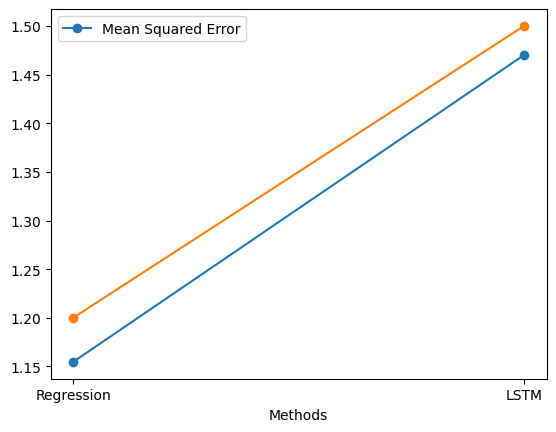

In [21]:
plt.plot(["Regression", "LSTM"], [1.1546453573093387, 1.4700841546058654], marker="o")
plt.plot(["Regression", "LSTM"], [1.2, 1.5], marker="o")
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: ..., Temp

Output: c(t+1)

In [12]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-07-28 14:04:17.504564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 14:04:17.506281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 14:04:17.507356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190435/190435 - 167s - loss: 1.4451 - accuracy: 0.3347 - 167s/epoch - 874us/step


2023-07-28 14:07:04.278224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 14:07:04.279599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 14:07:04.280447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

192615/192615 - 168s - loss: 1.4050 - accuracy: 0.3445 - 168s/epoch - 870us/step
190894/190894 - 165s - loss: 1.3931 - accuracy: 0.3457 - 165s/epoch - 866us/step
190453/190453 - 167s - loss: 1.3834 - accuracy: 0.3483 - 167s/epoch - 875us/step
190564/190564 - 165s - loss: 1.3829 - accuracy: 0.3462 - 165s/epoch - 868us/step
190967/190967 - 166s - loss: 1.3928 - accuracy: 0.3451 - 166s/epoch - 868us/step
190597/190597 - 165s - loss: 1.3934 - accuracy: 0.3454 - 165s/epoch - 868us/step
190599/190599 - 165s - loss: 1.3917 - accuracy: 0.3463 - 165s/epoch - 868us/step
190367/190367 - 164s - loss: 1.3912 - accuracy: 0.3458 - 164s/epoch - 861us/step
190068/190068 - 164s - loss: 1.3864 - accuracy: 0.3472 - 164s/epoch - 865us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.4656556844711304 - Accuracy: 43.28406751155853%
-------------------------------------------

### Method 2
Input: ..., Temp, ATemp

Output: c(t+1)

In [13]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-07-28 14:31:59.377181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 14:31:59.378509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 14:31:59.379279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190435/190435 - 166s - loss: 1.4322 - accuracy: 0.3344 - 166s/epoch - 869us/step


2023-07-28 14:34:45.187587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 14:34:45.189032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 14:34:45.190029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

192615/192615 - 167s - loss: 1.3730 - accuracy: 0.3445 - 167s/epoch - 865us/step
190894/190894 - 176s - loss: 1.3717 - accuracy: 0.3457 - 176s/epoch - 922us/step
190453/190453 - 188s - loss: 1.3641 - accuracy: 0.3483 - 188s/epoch - 988us/step
190564/190564 - 167s - loss: 1.3667 - accuracy: 0.3461 - 167s/epoch - 876us/step
190967/190967 - 172s - loss: 1.3756 - accuracy: 0.3448 - 172s/epoch - 900us/step
190597/190597 - 168s - loss: 1.3772 - accuracy: 0.3453 - 168s/epoch - 882us/step
190599/190599 - 168s - loss: 1.3731 - accuracy: 0.3460 - 168s/epoch - 882us/step
190367/190367 - 168s - loss: 1.3763 - accuracy: 0.3459 - 168s/epoch - 882us/step
190068/190068 - 168s - loss: 1.3713 - accuracy: 0.3473 - 168s/epoch - 885us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.5379207134246826 - Accuracy: 43.66517961025238%
-------------------------------------------

### Method 3
Input: ..., Temp, ATemp, Humidity

Output: c(t+1)

In [14]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Temp", "ATemp", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-07-28 15:00:33.061320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 15:00:33.062627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 15:00:33.063489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190435/190435 - 176s - loss: 1.4315 - accuracy: 0.3346 - 176s/epoch - 923us/step


2023-07-28 15:03:29.047810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 15:03:29.048927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 15:03:29.049931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

192615/192615 - 170s - loss: 1.3770 - accuracy: 0.3446 - 170s/epoch - 884us/step
190894/190894 - 169s - loss: 1.3731 - accuracy: 0.3457 - 169s/epoch - 886us/step
190453/190453 - 167s - loss: 1.3665 - accuracy: 0.3483 - 167s/epoch - 878us/step
190564/190564 - 171s - loss: 1.3682 - accuracy: 0.3461 - 171s/epoch - 899us/step
190967/190967 - 162s - loss: 1.3798 - accuracy: 0.3451 - 162s/epoch - 849us/step
190597/190597 - 163s - loss: 1.3781 - accuracy: 0.3454 - 163s/epoch - 856us/step
190599/190599 - 162s - loss: 1.3743 - accuracy: 0.3462 - 162s/epoch - 852us/step
190367/190367 - 162s - loss: 1.3771 - accuracy: 0.3458 - 162s/epoch - 850us/step
190068/190068 - 162s - loss: 1.3715 - accuracy: 0.3471 - 162s/epoch - 853us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.6798545122146606 - Accuracy: 43.65123510360718%
-------------------------------------------

### Method 4
Input: ..., Temp, ATemp, Humidity, WeatherSituation

Output: c(t+1)

In [15]:
dataset = pd.get_dummies(data=dataset, columns=["WeatherSituation"], dtype=int)

In [16]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-07-28 15:28:23.739995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 15:28:23.741322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 15:28:23.742296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190435/190435 - 165s - loss: 1.4256 - accuracy: 0.3343 - 165s/epoch - 865us/step


2023-07-28 15:31:08.820701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 15:31:08.822041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 15:31:08.823010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

192615/192615 - 166s - loss: 1.3652 - accuracy: 0.3444 - 166s/epoch - 862us/step
190894/190894 - 164s - loss: 1.3663 - accuracy: 0.3456 - 164s/epoch - 861us/step
190453/190453 - 164s - loss: 1.3614 - accuracy: 0.3483 - 164s/epoch - 859us/step
190564/190564 - 164s - loss: 1.3639 - accuracy: 0.3461 - 164s/epoch - 861us/step
190967/190967 - 164s - loss: 1.3735 - accuracy: 0.3451 - 164s/epoch - 858us/step
190597/190597 - 163s - loss: 1.3714 - accuracy: 0.3456 - 163s/epoch - 855us/step
190599/190599 - 163s - loss: 1.3657 - accuracy: 0.3464 - 163s/epoch - 854us/step
190367/190367 - 162s - loss: 1.3648 - accuracy: 0.3460 - 162s/epoch - 853us/step
190068/190068 - 163s - loss: 1.3588 - accuracy: 0.3475 - 163s/epoch - 856us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.5316287279129028 - Accuracy: 43.66517961025238%
-------------------------------------------

### Method 5
Input: ..., Temp, ATemp, Humidity, WeatherSituation, Windspeed

Output: c(t+1)

In [17]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Humidity", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-07-28 15:55:47.074265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 15:55:47.075976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 15:55:47.076905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190435/190435 - 164s - loss: 1.4297 - accuracy: 0.3346 - 164s/epoch - 862us/step


2023-07-28 15:58:31.478741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 15:58:31.480033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 15:58:31.480890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

192615/192615 - 165s - loss: 1.3854 - accuracy: 0.3446 - 165s/epoch - 859us/step
190894/190894 - 163s - loss: 1.3766 - accuracy: 0.3457 - 163s/epoch - 856us/step
190453/190453 - 163s - loss: 1.3750 - accuracy: 0.3484 - 163s/epoch - 856us/step
190564/190564 - 166s - loss: 1.3739 - accuracy: 0.3462 - 166s/epoch - 871us/step
190967/190967 - 164s - loss: 1.3766 - accuracy: 0.3451 - 164s/epoch - 861us/step
190597/190597 - 164s - loss: 1.3780 - accuracy: 0.3453 - 164s/epoch - 861us/step
190599/190599 - 164s - loss: 1.3757 - accuracy: 0.3461 - 164s/epoch - 861us/step
190367/190367 - 164s - loss: 1.3751 - accuracy: 0.3458 - 164s/epoch - 861us/step
190068/190068 - 164s - loss: 1.3707 - accuracy: 0.3471 - 164s/epoch - 863us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.5717008113861084 - Accuracy: 43.66517961025238%
-------------------------------------------

### Method 6
Input: ..., Temp, ATemp, WeatherSituation, Windspeed

Output: c(t+1)

In [18]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-07-28 16:23:15.286913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 16:23:15.288141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 16:23:15.289110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190435/190435 - 164s - loss: 1.4304 - accuracy: 0.3345 - 164s/epoch - 861us/step


2023-07-28 16:25:59.467414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 16:25:59.468647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 16:25:59.469531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

192615/192615 - 164s - loss: 1.3744 - accuracy: 0.3444 - 164s/epoch - 853us/step
190894/190894 - 163s - loss: 1.3702 - accuracy: 0.3453 - 163s/epoch - 853us/step
190453/190453 - 163s - loss: 1.3593 - accuracy: 0.3479 - 163s/epoch - 854us/step
190564/190564 - 164s - loss: 1.3590 - accuracy: 0.3456 - 164s/epoch - 858us/step
190967/190967 - 163s - loss: 1.3686 - accuracy: 0.3446 - 163s/epoch - 854us/step
190597/190597 - 163s - loss: 1.3669 - accuracy: 0.3448 - 163s/epoch - 857us/step
190599/190599 - 163s - loss: 1.3629 - accuracy: 0.3455 - 163s/epoch - 855us/step
190367/190367 - 163s - loss: 1.3616 - accuracy: 0.3452 - 163s/epoch - 855us/step
190068/190068 - 162s - loss: 1.3579 - accuracy: 0.3465 - 162s/epoch - 853us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.4585264921188354 - Accuracy: 43.66517961025238%
-------------------------------------------

### Method 7
Input: ..., Temp, Humidity, WeatherSituation, Windspeed

Output: c(t+1)

In [19]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Temp", "Humidity", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-07-28 16:50:32.361603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 16:50:32.363120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 16:50:32.364430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190435/190435 - 165s - loss: 1.4312 - accuracy: 0.3343 - 165s/epoch - 866us/step


2023-07-28 16:53:17.599579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 16:53:17.600795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 16:53:17.601668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

192615/192615 - 165s - loss: 1.3832 - accuracy: 0.3445 - 165s/epoch - 858us/step
190894/190894 - 164s - loss: 1.3721 - accuracy: 0.3457 - 164s/epoch - 859us/step
190453/190453 - 164s - loss: 1.3587 - accuracy: 0.3484 - 164s/epoch - 863us/step
190564/190564 - 164s - loss: 1.3587 - accuracy: 0.3462 - 164s/epoch - 860us/step
190967/190967 - 164s - loss: 1.3675 - accuracy: 0.3452 - 164s/epoch - 857us/step
190597/190597 - 163s - loss: 1.3647 - accuracy: 0.3456 - 163s/epoch - 855us/step
190599/190599 - 163s - loss: 1.3537 - accuracy: 0.3464 - 163s/epoch - 857us/step
190367/190367 - 163s - loss: 1.3548 - accuracy: 0.3461 - 163s/epoch - 858us/step
190068/190068 - 163s - loss: 1.3471 - accuracy: 0.3475 - 163s/epoch - 856us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.5665247440338135 - Accuracy: 43.646588921546936%
------------------------------------------

### Method 8
Input: ..., Temp, Humidity, Windspeed

Output: c(t+1)

In [20]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Temp", "Humidity", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_absolute_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-07-28 17:17:56.675184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 17:17:56.676816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 17:17:56.677807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190435/190435 - 168s - loss: 1.4383 - accuracy: 0.3346 - 168s/epoch - 885us/step


2023-07-28 17:20:45.415077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-28 17:20:45.416219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-28 17:20:45.417049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

192615/192615 - 173s - loss: 1.3955 - accuracy: 0.3446 - 173s/epoch - 897us/step
190894/190894 - 171s - loss: 1.3872 - accuracy: 0.3457 - 171s/epoch - 897us/step
190453/190453 - 170s - loss: 1.3704 - accuracy: 0.3483 - 170s/epoch - 894us/step
190564/190564 - 171s - loss: 1.3691 - accuracy: 0.3462 - 171s/epoch - 899us/step
190967/190967 - 172s - loss: 1.3765 - accuracy: 0.3452 - 172s/epoch - 899us/step
190597/190597 - 172s - loss: 1.3747 - accuracy: 0.3456 - 172s/epoch - 900us/step
190599/190599 - 170s - loss: 1.3675 - accuracy: 0.3464 - 170s/epoch - 894us/step
190367/190367 - 170s - loss: 1.3660 - accuracy: 0.3461 - 170s/epoch - 893us/step
190068/190068 - 170s - loss: 1.3565 - accuracy: 0.3475 - 170s/epoch - 896us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.5132001638412476 - Accuracy: 43.66517961025238%
-------------------------------------------

## Regression

In [29]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score

In [31]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Temp", "ATemp", "WeatherSituation_1.0", "WeatherSituation_2.0", "WeatherSituation_3.0", "WeatherSituation_4.0", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

lm = linear_model.LinearRegression()
scores = cross_val_score(lm, X, y, cv=100, scoring="neg_median_absolute_error", groups=dataset["WorkingDay"])
scores2 = np.array([round(x) for x in scores])

mse = abs(scores.mean())
print(f"Mean Absolute Error: {mse}")
mse = abs(scores2.mean())
print(f"Mean Absolute Error: {mse}")

Mean Absolute Error: 1.1378324783630496
Mean Absolute Error: 1.0


## Graphs

Text(0.5, 0, 'Methods')

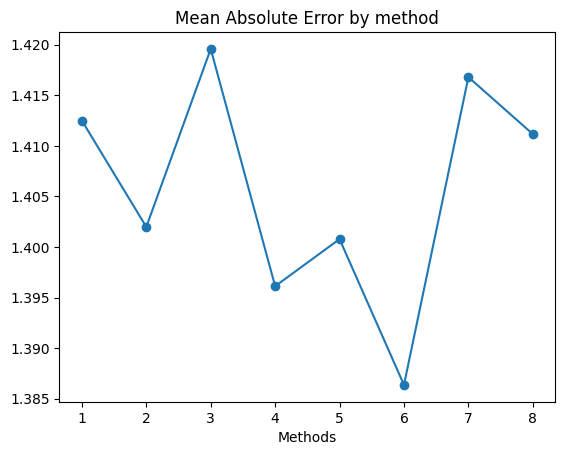

In [25]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Absolute Error by method")
plt.xlabel("Methods")

Text(0.5, 0, 'Methods')

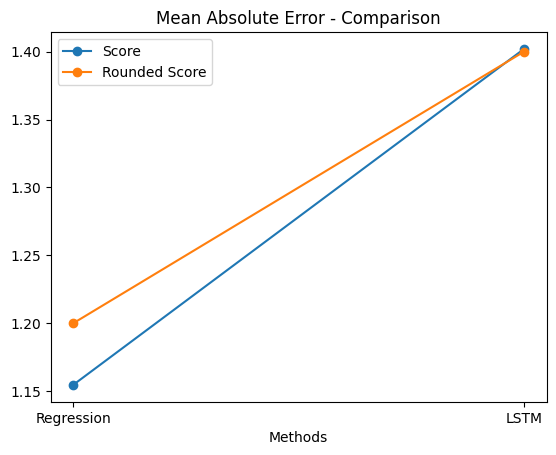

In [27]:
plt.plot(["Regression", "LSTM"], [1.1546453573093387, 1.4019839406013488], marker="o")
plt.plot(["Regression", "LSTM"], [1.2, 1.4], marker="o")
plt.title("Mean Absolute Error - Comparison")
plt.legend(["Score", "Rounded Score"])
plt.xlabel("Methods")